Loaded 85000 samples, 10 variables.


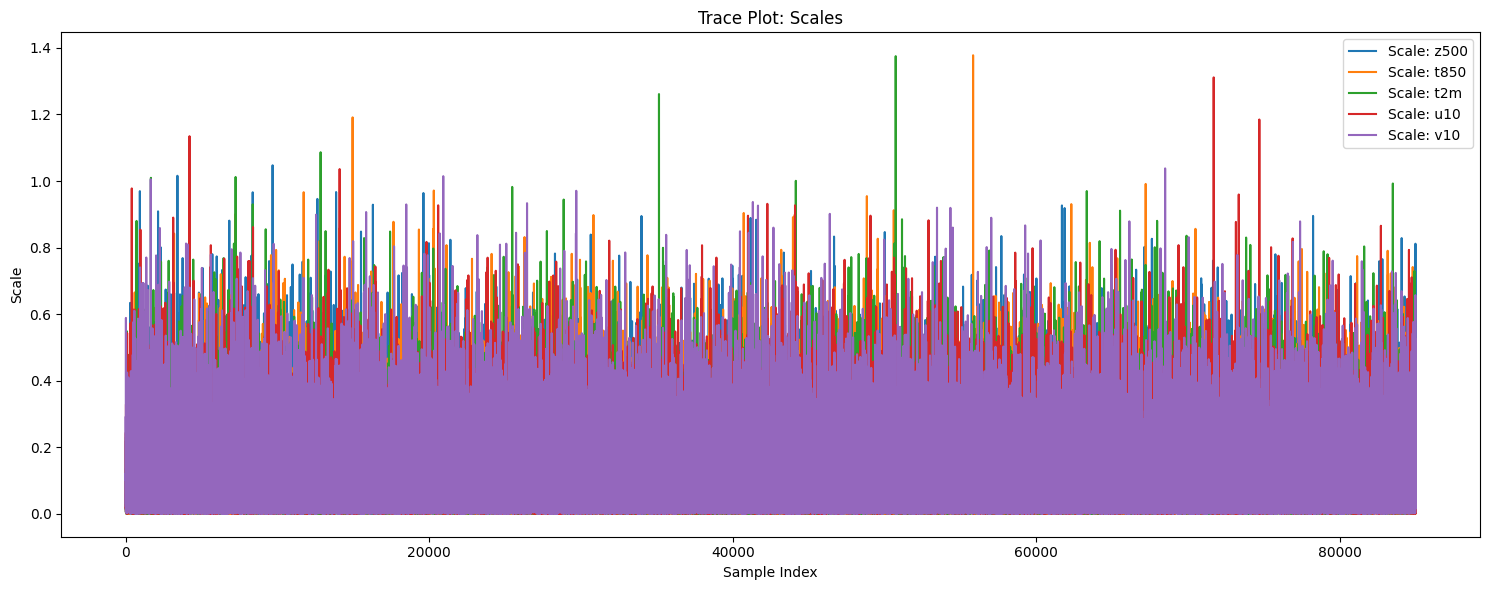

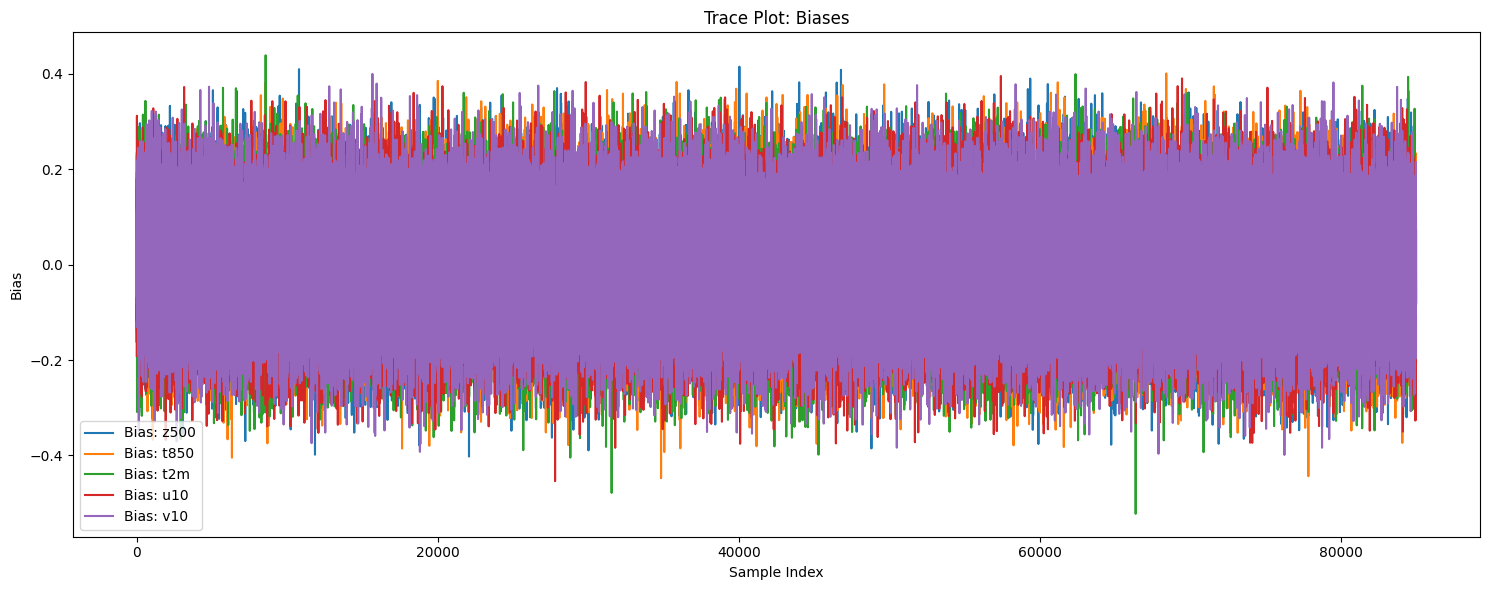

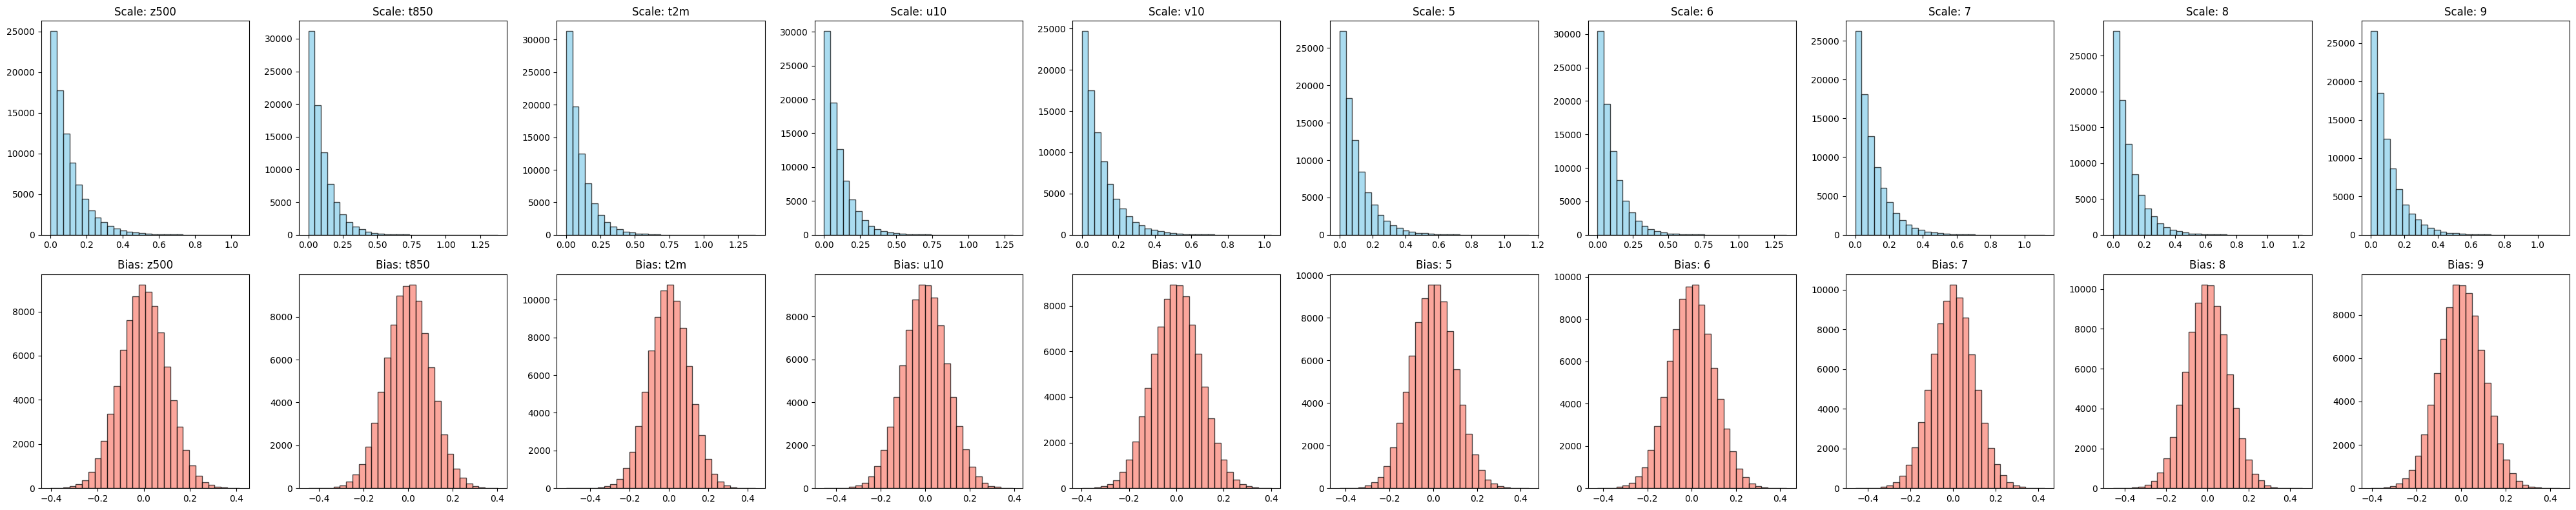

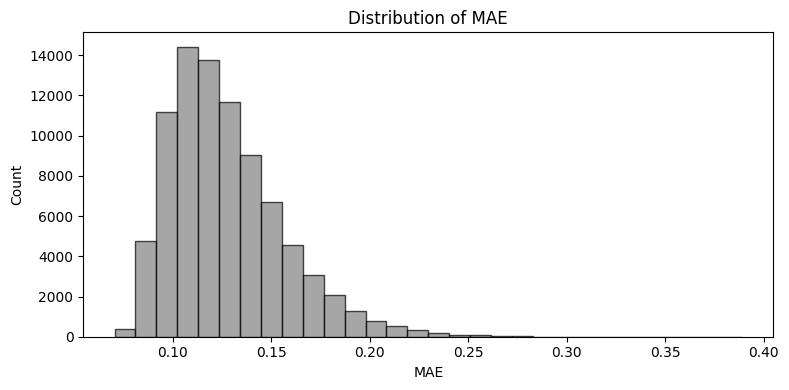

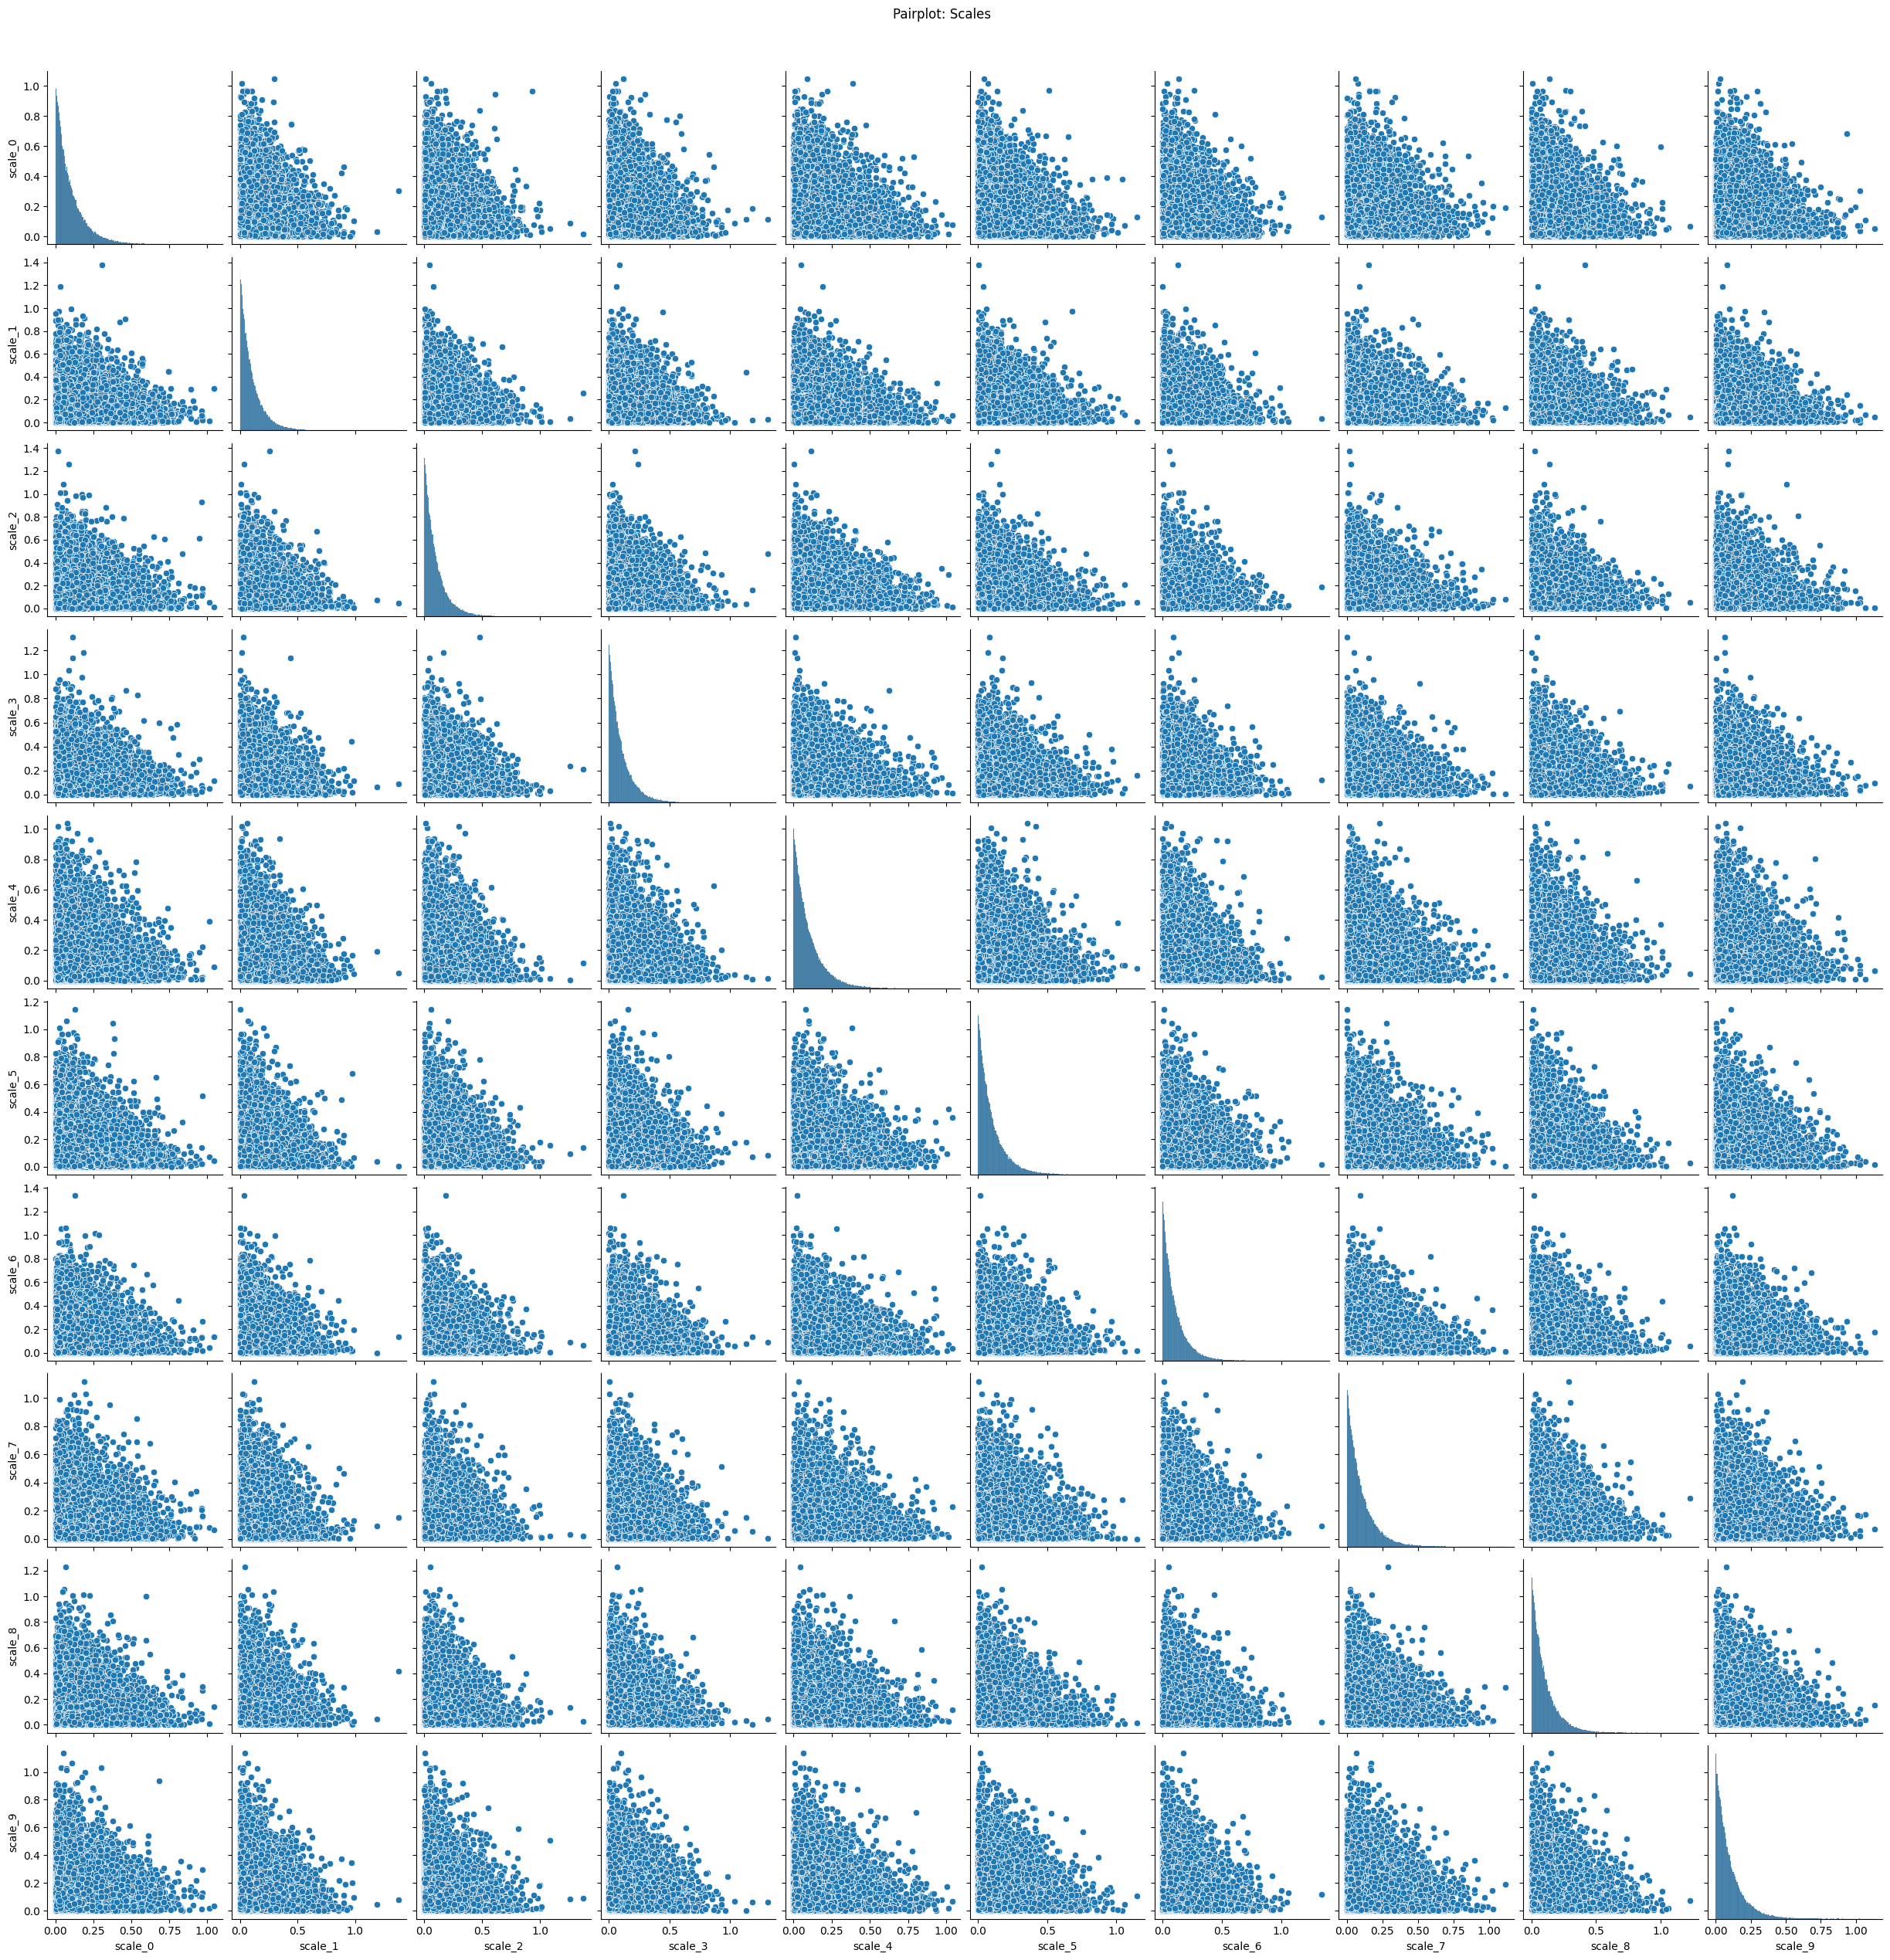

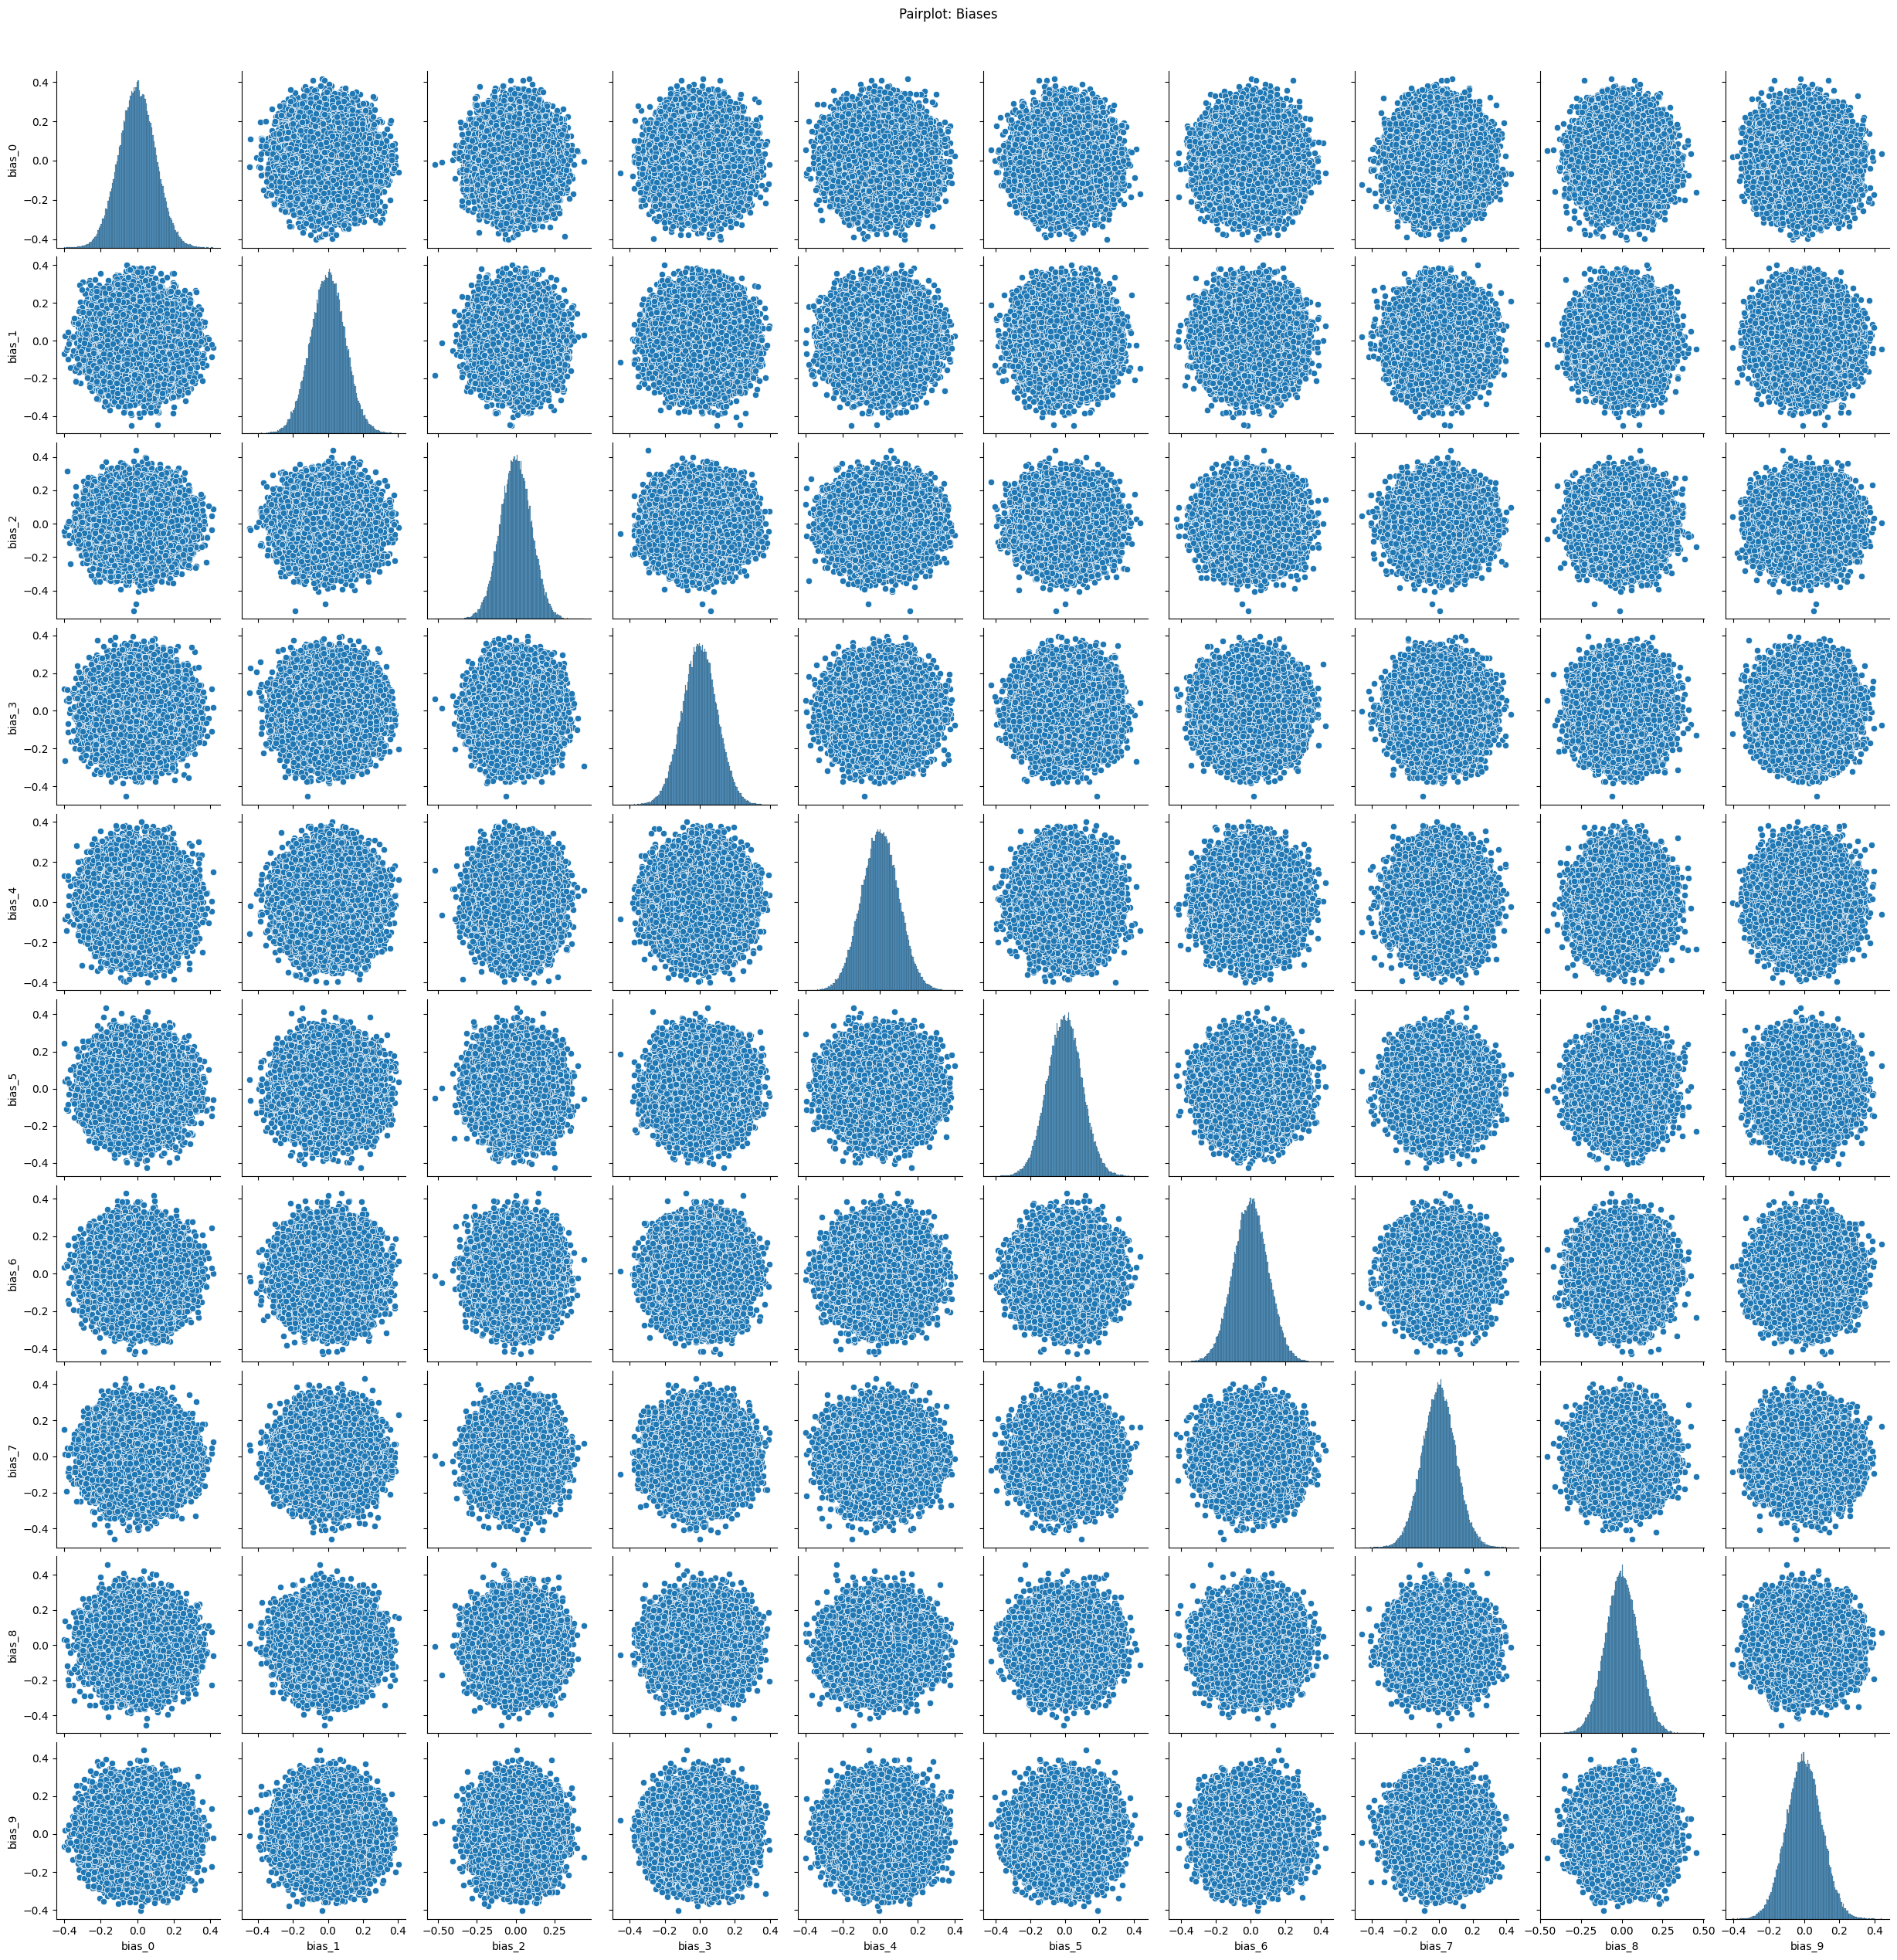


Posterior Means (scales): [0.10016338 0.1001873  0.09989108 0.09959776 0.10096756 0.09966909
 0.10028247 0.10033276 0.10046811 0.10048286]
Posterior Vars (scales): [0.01008441 0.00998236 0.0100303  0.00982295 0.01025463 0.01002085
 0.01004892 0.01000546 0.01010975 0.01012612]
Posterior Means (biases): [ 3.28578649e-04  2.03149725e-04  3.13498638e-04 -4.84053987e-04
  5.67617292e-04 -2.70788908e-04 -4.25120074e-05 -1.53325122e-05
  9.09537778e-05  2.51129080e-04]
Posterior Vars (biases): [0.01003208 0.00995363 0.0100575  0.00998211 0.01000024 0.01003544
 0.01000645 0.00997938 0.01001486 0.01003172]
MAE: mean=0.1272, var=0.0008, min=0.0703, max=0.3890


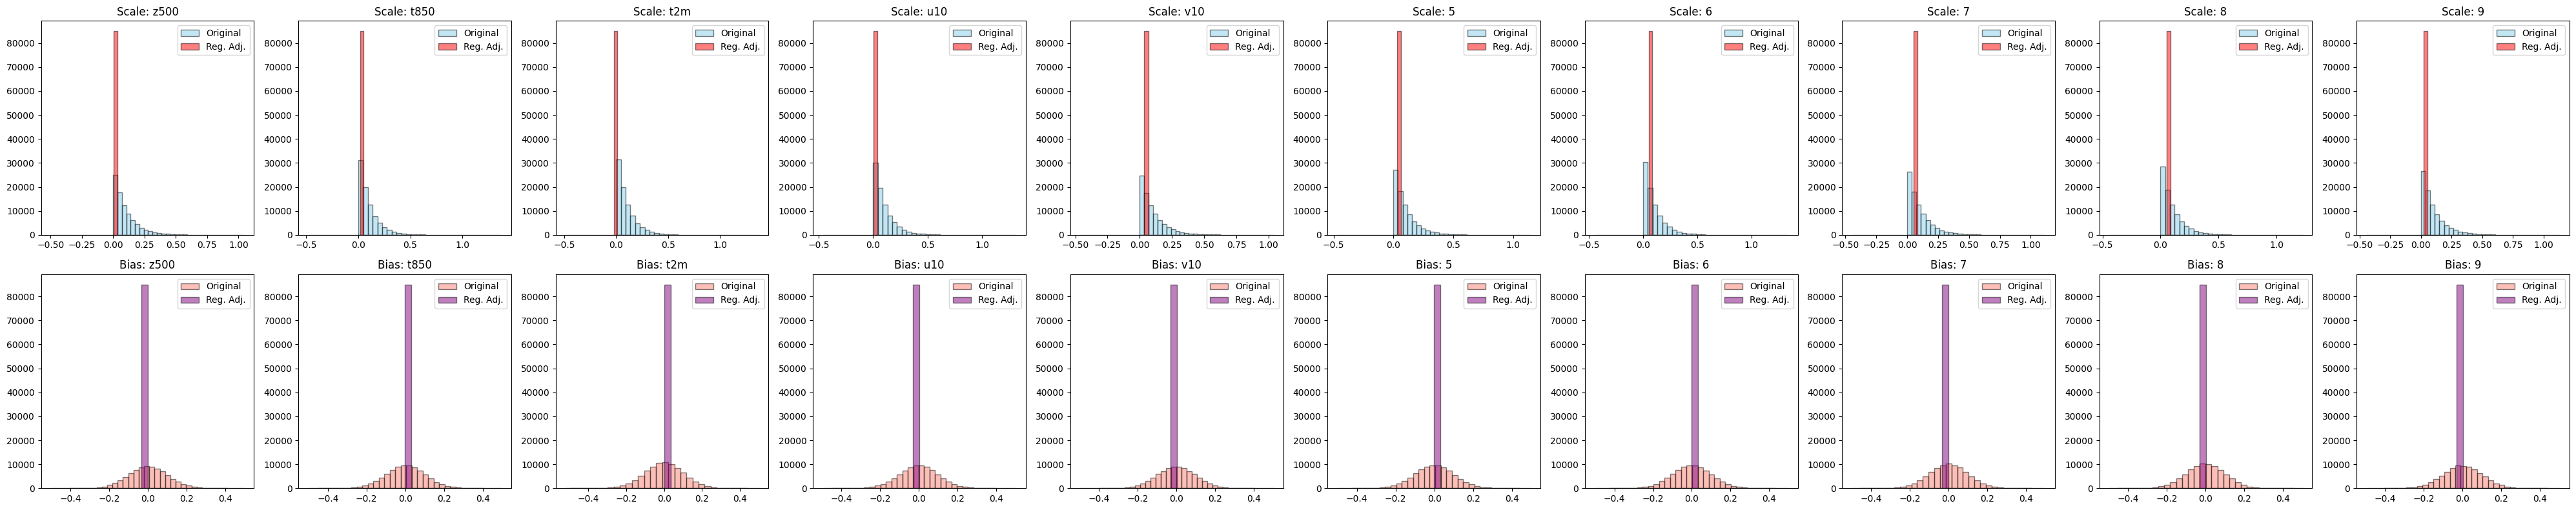


Regression-adjusted Posterior Means (scales): [0.00194787 0.01691522 0.01034693 0.03644109 0.03540731 0.02886023
 0.05228688 0.05115423 0.05528142 0.05365154]
Regression-adjusted Posterior Vars (scales): [4.55271783e-32 3.02131464e-28 1.52938822e-28 2.70900536e-28
 1.70170475e-27 5.86450483e-30 1.04422232e-27 1.25626792e-27
 1.21867844e-27 4.60530294e-29]
Regression-adjusted Posterior Means (biases): [-0.00266251 -0.00234351  0.00171767  0.00265381  0.00118164 -0.00219068
 -0.00314355 -0.00100053  0.00234998  0.00265697]
Regression-adjusted Posterior Vars (biases): [1.42545316e-30 8.14314778e-30 1.59486259e-30 5.79539422e-30
 8.70609155e-31 2.63077517e-30 8.61766400e-30 2.20950738e-30
 7.19578585e-31 4.94965876e-30]
Regression-adjusted summary metrics saved to results/deterministic-iterative-6h/abc_gibbs_regression_adjusted_summary_metrics.json


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import pandas as pd
from sklearn.linear_model import LinearRegression

# --- CONFIG ---
result_path = Path("results/deterministic-iterative-6h")  # <-- change as needed
variable_names = ['z500', 't850', 't2m', 'u10', 'v10']

# --- LOAD ALL SAMPLES ---
npz_files = sorted(result_path.glob("abc_gibbs_sample_*.npz"))
json_files = sorted(result_path.glob("abc_gibbs_sample_*_summary.json"))

all_scales, all_biases, all_mae = [], [], []
for npz in npz_files:
    data = np.load(npz)
    all_scales.append(data['scales'])
    all_biases.append(data['biases'])
    all_mae.append(data['mae'])

scales = np.concatenate(all_scales, axis=0)
biases = np.concatenate(all_biases, axis=0)
mae = np.concatenate(all_mae, axis=0)

print(f"Loaded {scales.shape[0]} samples, {scales.shape[1]} variables.")

# --- TRACE PLOTS ---
plt.figure(figsize=(15, 6))
for v in range(min(scales.shape[1], len(variable_names))):
    plt.plot(scales[:, v], label=f'Scale: {variable_names[v]}')
plt.title("Trace Plot: Scales")
plt.xlabel("Sample Index")
plt.ylabel("Scale")
plt.legend()
plt.tight_layout()
plt.savefig(result_path / "trace_scales.png")
plt.show()

plt.figure(figsize=(15, 6))
for v in range(min(biases.shape[1], len(variable_names))):
    plt.plot(biases[:, v], label=f'Bias: {variable_names[v]}')
plt.title("Trace Plot: Biases")
plt.xlabel("Sample Index")
plt.ylabel("Bias")
plt.legend()
plt.tight_layout()
plt.savefig(result_path / "trace_biases.png")
plt.show()

# --- MARGINAL HISTOGRAMS ---
fig, axs = plt.subplots(2, scales.shape[1], figsize=(4*scales.shape[1], 8))
for v in range(scales.shape[1]):
    axs[0, v].hist(scales[:, v], bins=30, color='skyblue', edgecolor='k', alpha=0.7)
    axs[0, v].set_title(f'Scale: {variable_names[v] if v < len(variable_names) else v}')
    axs[1, v].hist(biases[:, v], bins=30, color='salmon', edgecolor='k', alpha=0.7)
    axs[1, v].set_title(f'Bias: {variable_names[v] if v < len(variable_names) else v}')
plt.tight_layout()
plt.savefig(result_path / "marginals_scales_biases.png")
plt.show()

# --- MAE DISTRIBUTION ---
plt.figure(figsize=(8, 4))
plt.hist(mae, bins=30, color='gray', edgecolor='k', alpha=0.7)
plt.title("Distribution of MAE")
plt.xlabel("MAE")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(result_path / "mae_distribution.png")
plt.show()

# --- PAIRPLOTS (JOINT DISTRIBUTIONS) ---
df = pd.DataFrame(scales, columns=[f"scale_{v}" for v in range(scales.shape[1])])
sns.pairplot(df)
plt.suptitle("Pairplot: Scales", y=1.02)
plt.savefig(result_path / "pairplot_scales.png")
plt.show()

dfb = pd.DataFrame(biases, columns=[f"bias_{v}" for v in range(biases.shape[1])])
sns.pairplot(dfb)
plt.suptitle("Pairplot: Biases", y=1.02)
plt.savefig(result_path / "pairplot_biases.png")
plt.show()

# --- SUMMARY STATISTICS ---
print("\nPosterior Means (scales):", np.mean(scales, axis=0))
print("Posterior Vars (scales):", np.var(scales, axis=0))
print("Posterior Means (biases):", np.mean(biases, axis=0))
print("Posterior Vars (biases):", np.var(biases, axis=0))
print(f"MAE: mean={np.mean(mae):.4f}, var={np.var(mae):.4f}, min={np.min(mae):.4f}, max={np.max(mae):.4f}")

# --- REGRESSION POST-PROCESSING (Beaumont adjustment) ---
scales_reg_adj = np.zeros_like(scales)
biases_reg_adj = np.zeros_like(biases)
for var_idx in range(scales.shape[1]):
    # Log-linear for scales
    reg_scale = LinearRegression().fit(mae.reshape(-1, 1), np.log(scales[:, var_idx]))
    scales_reg_adj[:, var_idx] = np.exp(reg_scale.predict(np.zeros((len(mae), 1))))
    # Linear for biases
    reg_bias = LinearRegression().fit(mae.reshape(-1, 1), biases[:, var_idx])
    biases_reg_adj[:, var_idx] = reg_bias.predict(np.zeros((len(mae), 1)))

# Plot regression-adjusted vs original
fig, axs = plt.subplots(2, scales.shape[1], figsize=(4*scales.shape[1], 8))
for v in range(scales.shape[1]):
    axs[0, v].hist(scales[:, v], bins=30, color='skyblue', edgecolor='k', alpha=0.5, label='Original')
    axs[0, v].hist(scales_reg_adj[:, v], bins=30, color='red', edgecolor='k', alpha=0.5, label='Reg. Adj.')
    axs[0, v].set_title(f'Scale: {variable_names[v] if v < len(variable_names) else v}')
    axs[1, v].hist(biases[:, v], bins=30, color='salmon', edgecolor='k', alpha=0.5, label='Original')
    axs[1, v].hist(biases_reg_adj[:, v], bins=30, color='purple', edgecolor='k', alpha=0.5, label='Reg. Adj.')
    axs[1, v].set_title(f'Bias: {variable_names[v] if v < len(variable_names) else v}')
    axs[0, v].legend()
    axs[1, v].legend()
plt.tight_layout()
plt.savefig(result_path / "regression_adjusted_histograms.png")
plt.show()

print("\nRegression-adjusted Posterior Means (scales):", np.mean(scales_reg_adj, axis=0))
print("Regression-adjusted Posterior Vars (scales):", np.var(scales_reg_adj, axis=0))
print("Regression-adjusted Posterior Means (biases):", np.mean(biases_reg_adj, axis=0))
print("Regression-adjusted Posterior Vars (biases):", np.var(biases_reg_adj, axis=0))

# --- Save regression-adjusted summary metrics ---
summary_metrics_reg = {
    "posterior_mean_scales_reg": np.mean(scales_reg_adj, axis=0).tolist(),
    "posterior_var_scales_reg": np.var(scales_reg_adj, axis=0).tolist(),
    "posterior_mean_biases_reg": np.mean(biases_reg_adj, axis=0).tolist(),
    "posterior_var_biases_reg": np.var(biases_reg_adj, axis=0).tolist()
}
with open(result_path / "abc_gibbs_regression_adjusted_summary_metrics.json", "w") as f:
    json.dump(summary_metrics_reg, f, indent=2)
print(f"Regression-adjusted summary metrics saved to {result_path / 'abc_gibbs_regression_adjusted_summary_metrics.json'}")

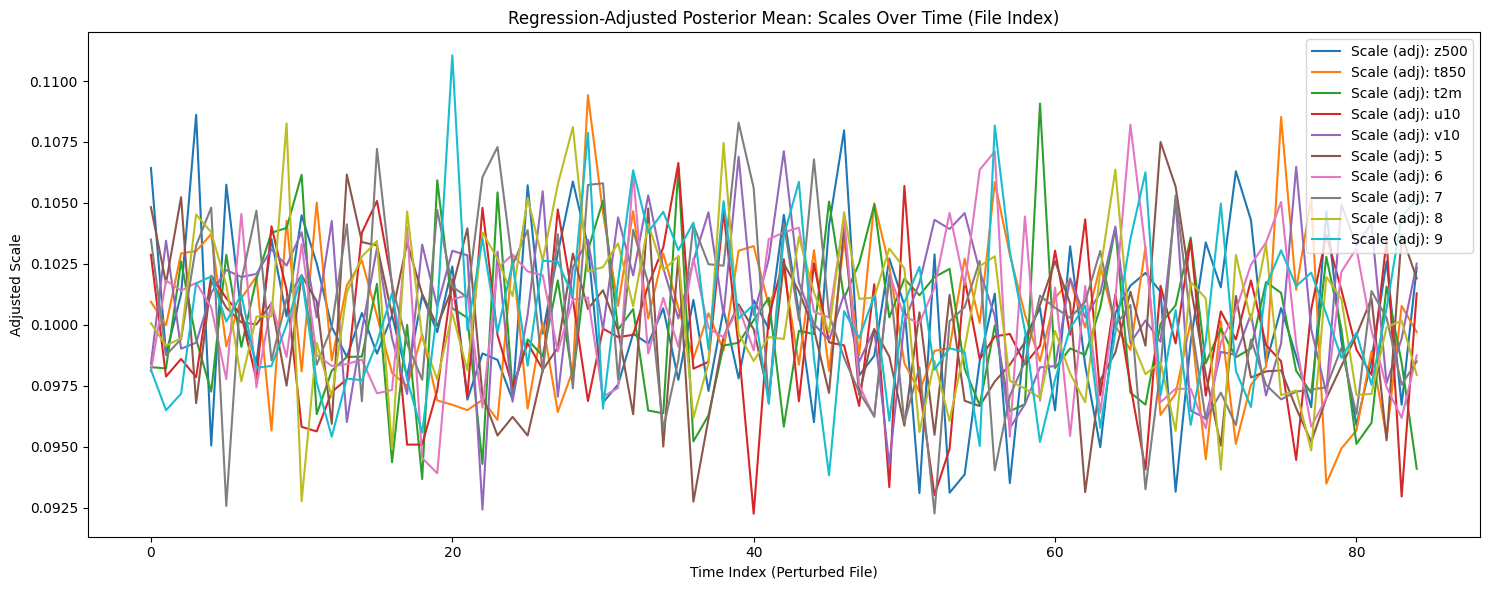

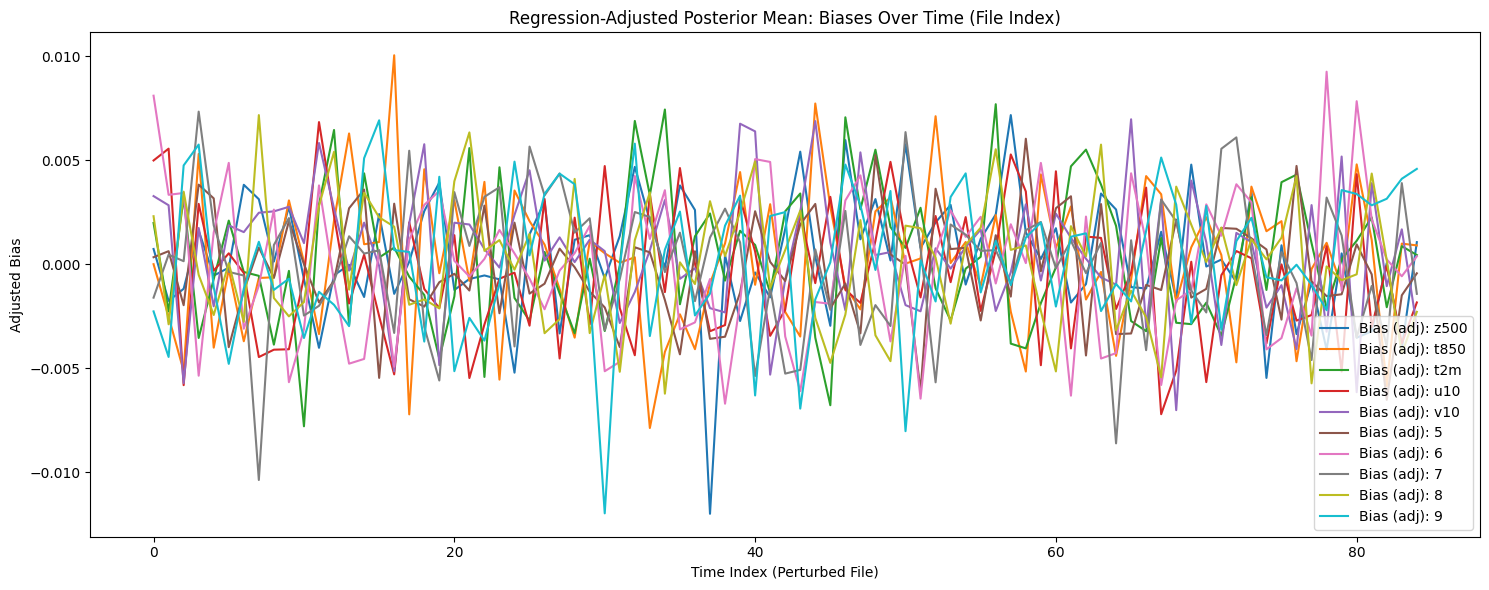

In [4]:
# --- Aggregate regression-adjusted means over time (file index) ---
import glob

# Find all summary files in order
summary_files = sorted(result_path.glob("abc_gibbs_sample_*_summary.json"))

# Load regression-adjusted means for each file (time index)
mean_scales_time = []
mean_biases_time = []
for f in summary_files:
    with open(f, "r") as jf:
        summary = json.load(jf)
        # Use regression-adjusted means if available, else fallback to vanilla
        if "posterior_mean_scales_reg" in summary:
            mean_scales_time.append(summary["posterior_mean_scales_reg"])
            mean_biases_time.append(summary["posterior_mean_biases_reg"])
        else:
            mean_scales_time.append(summary["posterior_mean_scales"])
            mean_biases_time.append(summary["posterior_mean_biases"])

mean_scales_time = np.array(mean_scales_time)  # shape: (n_times, n_vars)
mean_biases_time = np.array(mean_biases_time)

# --- Plot regression-adjusted posterior means over time (file/time index) ---
plt.figure(figsize=(15, 6))
for v in range(mean_scales_time.shape[1]):
    plt.plot(mean_scales_time[:, v], label=f'Scale (adj): {variable_names[v] if v < len(variable_names) else v}')
plt.title("Regression-Adjusted Posterior Mean: Scales Over Time (File Index)")
plt.xlabel("Time Index (Perturbed File)")
plt.ylabel("Adjusted Scale")
plt.legend()
plt.tight_layout()
plt.savefig(result_path / "regression_adjusted_scales_over_time_by_file.png")
plt.show()

plt.figure(figsize=(15, 6))
for v in range(mean_biases_time.shape[1]):
    plt.plot(mean_biases_time[:, v], label=f'Bias (adj): {variable_names[v] if v < len(variable_names) else v}')
plt.title("Regression-Adjusted Posterior Mean: Biases Over Time (File Index)")
plt.xlabel("Time Index (Perturbed File)")
plt.ylabel("Adjusted Bias")
plt.legend()
plt.tight_layout()
plt.savefig(result_path / "regression_adjusted_biases_over_time_by_file.png")
plt.show()

/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner

Scale z500: Best ARMA order (0, 0, 0), AIC=-723.55


/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Scale t850: Best ARMA order (0, 0, 2), AIC=-741.19


/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Scale t2m: Best ARMA order (0, 0, 0), AIC=-736.02
Scale u10: Best ARMA order (0, 0, 0), AIC=-734.69


/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Scale v10: Best ARMA order (0, 0, 0), AIC=-746.72
Scale 5: Best ARMA order (0, 0, 2), AIC=-739.13


/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner

Scale 6: Best ARMA order (0, 0, 0), AIC=-739.90


/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner

Scale 7: Best ARMA order (0, 0, 0), AIC=-716.13
Scale 8: Best ARMA order (0, 0, 0), AIC=-732.85


/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Scale 9: Best ARMA order (0, 0, 0), AIC=-726.80


/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Bias z500: Best ARMA order (0, 0, 0), AIC=-749.18


/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Bias t850: Best ARMA order (0, 0, 1), AIC=-722.62


/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Bias t2m: Best ARMA order (0, 0, 0), AIC=-726.84


/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner

Bias u10: Best ARMA order (0, 0, 1), AIC=-733.35


/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Bias v10: Best ARMA order (0, 0, 1), AIC=-745.42


/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Bias 5: Best ARMA order (0, 0, 1), AIC=-772.87


/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Bias 6: Best ARMA order (1, 0, 2), AIC=-713.66


/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner

Bias 7: Best ARMA order (0, 0, 0), AIC=-727.13


/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner

Bias 8: Best ARMA order (1, 0, 3), AIC=-742.57


/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner/Development/imperial/research_project/msc_research_project/Continuous-Ensemble-Forecasting/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ashleyturner

Bias 9: Best ARMA order (1, 0, 2), AIC=-720.06


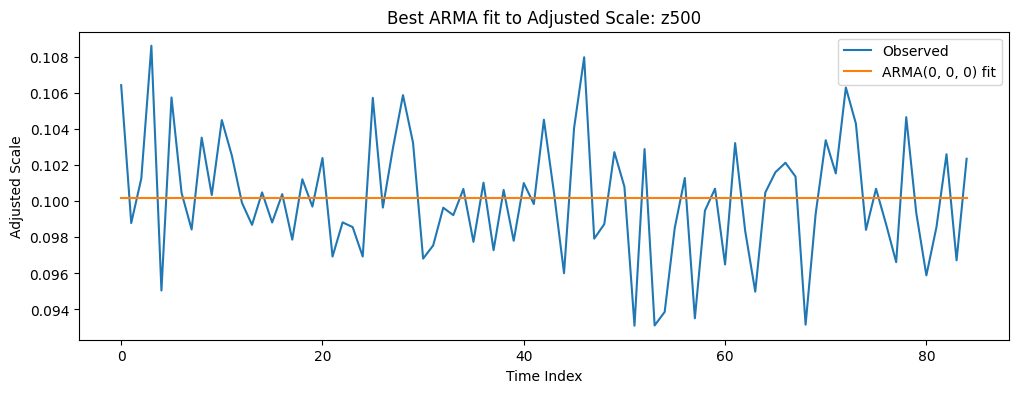

In [10]:
import statsmodels.api as sm

# Fit ARMA/ARIMA model with automatic order selection using AIC for each variable's time series

arma_results_scales = []
arma_orders_scales = []
arma_results_biases = []
arma_orders_biases = []

for v in range(mean_scales_time.shape[1]):
    series = mean_scales_time[:, v]
    # Use auto_arima for automatic order selection (requires pmdarima), or use ARIMA with order selection via AIC
    # Here, we use statsmodels' ARIMA with order selection
    best_aic = np.inf
    best_order = None
    best_result = None
    # Try a reasonable range of (p, q)
    for p in range(4):
        for q in range(4):
            try:
                model = sm.tsa.ARIMA(series, order=(p, 0, q))
                result = model.fit()
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = (p, 0, q)
                    best_result = result
            except Exception:
                continue
    arma_results_scales.append(best_result)
    arma_orders_scales.append(best_order)
    print(f"Scale {variable_names[v] if v < len(variable_names) else v}: Best ARMA order {best_order}, AIC={best_aic:.2f}")

for v in range(mean_biases_time.shape[1]):
    series = mean_biases_time[:, v]
    best_aic = np.inf
    best_order = None
    best_result = None
    for p in range(4):
        for q in range(4):
            try:
                model = sm.tsa.ARIMA(series, order=(p, 0, q))
                result = model.fit()
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = (p, 0, q)
                    best_result = result
            except Exception:
                continue
    arma_results_biases.append(best_result)
    arma_orders_biases.append(best_order)
    print(f"Bias {variable_names[v] if v < len(variable_names) else v}: Best ARMA order {best_order}, AIC={best_aic:.2f}")

# Example plot for first variable
v = 0
plt.figure(figsize=(12, 4))
plt.plot(mean_scales_time[:, v], label='Observed')
plt.plot(arma_results_scales[v].fittedvalues, label=f'ARMA{arma_orders_scales[v]} fit')
plt.title(f"Best ARMA fit to Adjusted Scale: {variable_names[v] if v < len(variable_names) else v}")
plt.xlabel("Time Index")
plt.ylabel("Adjusted Scale")
plt.legend()
plt.show()
